# **Sarcasm detection using Natural Language Processing**
#### This model is being trained with dataset from Kaggle. Dataset sourced from TheOnion and HuffPost. Saracastic dataset from TheOnion and the serious tone data from HuffingtonPost


# **List of libraries used with documentation hyperlinks for reference**
*   [NumPy](https://numpy.org/doc/1.23/) 
*   [Pandas](https://pandas.pydata.org/docs/getting_started/index.html#getting-started)
*   [Matplotlib](https://matplotlib.org/2.0.2/api/pyplot_api.html)
*   [TensorFlow](https://www.tensorflow.org/guide/basics)
*   [seaborn](https://seaborn.pydata.org/tutorial.html)
*   [Natural Language Tool Kit(nltk)](https://www.nltk.org/py-modindex.html)
*   [Regular Expressions(re)](https://docs.python.org/3/library/re.html)
*   [keras]()




In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import nltk
import re,string,unicodedata
nltk.download('stopwords')
from nltk.corpus import stopwords

#keras imports
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras_preprocessing.sequence import pad_sequences


import warnings

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [51]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [52]:
warnings.filterwarnings("ignore")

In [53]:
jsonpath = input("Enter the source json path: ")
df = pd.read_json(jsonpath, lines=True)
df.head()

Enter the source json path: /content/drive/MyDrive/Colab Notebooks/Sarcasm Detection/Sarcasm Headlines Dataset.json


,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


In [54]:
# Check for null values and duplicates
print("Null",'\n', df.isnull().sum())
print('\033[1m'+'Duplicates', df['headline'].duplicated().sum())

Null 
 is_sarcastic    0
headline        0
article_link    0
dtype: int64
Duplicates 116


In [55]:
print("Removed duplicates")
df=df.drop(df[df['headline'].duplicated()].index,axis=0)

Removed duplicates


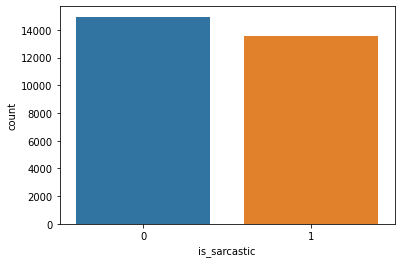

In [56]:
sns.countplot(df['is_sarcastic']);

In [57]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

def split_into_words(text):
    words = text.split()
    return words

def to_lower_case(words):
    words = [word.lower() for word in words]
    return words

def remove_punctuation(words):
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    stripped = [re_punc.sub('', w) for w in words]
    return stripped

def keep_alphabetic(words):
    words = [word for word in words if word.isalpha()]
    return words

def remove_stopwords(words):
    stop_words = set(stopwords.words('english'))
    words = [i for i in words if not i in stop_words]
    return words

def to_sentence(words):
    #join to form sentence
    return ' '.join(words)

#Removing the noisy text
def denoise_text(text):
    words = split_into_words(text)
    words = to_lower_case(words)
    words = remove_punctuation(words)
    words = keep_alphabetic(words)
    words = remove_stopwords(words)
    return to_sentence(words)

In [58]:
df['headline']=df['headline'].apply(denoise_text)

In [59]:
labels = (df['is_sarcastic'])
data = (df['headline'])

# **Split data for train and test**

In [60]:
train_ratio = 0.80

train_size = int(len(labels)*train_ratio)

train_data = data[:train_size]
train_labels= labels[:train_size]

test_data = data[train_size:]
test_labels = labels[train_size:]

# **Tokenization and Padding**

In [61]:
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(train_data)

vocab_size = len(tokenizer.word_index)
print(vocab_size)

train_sequences = tokenizer.texts_to_sequences(train_data)
test_sequences = tokenizer.texts_to_sequences(test_data)

25662


In [62]:
maxlen=max([len(i) for i in train_sequences])

In [63]:
train_padded = pad_sequences(train_sequences, maxlen=maxlen,  padding='post')
test_padded = pad_sequences(test_sequences, maxlen=maxlen,  padding='post')

In [64]:
# Print a sample headline
index = 10
print(f'sample headline: {train_sequences[index]}')
print(f'padded sequence: {train_padded[index]} \n')

print(f'Original Sentence:  \n {tokenizer.sequences_to_texts(train_sequences[index:index+1])} \n')

# Print dimensions of padded sequences
print(f'shape of padded sequences: {train_padded.shape}')

sample headline: [1972, 2572, 315, 3022, 943, 7]
padded sequence: [1972 2572  315 3022  943    7    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0] 

Original Sentence:  
 ['lesbian considered father indiana amazing one'] 

shape of padded sequences: (22802, 106)


In [65]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1,100,input_length=maxlen),
    tf.keras.layers.Bidirectional( tf.keras.layers.LSTM(128)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.50),
    tf.keras.layers.Dense(64,activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 106, 100)          2566300   
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              234496    
 nal)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                      

In [66]:
history=model.fit(train_padded, np.array(train_labels),validation_data = (test_padded,np.array(test_labels)) , epochs = 5 , verbose=2)

Epoch 1/5
713/713 - 268s - loss: 0.4795 - accuracy: 0.7607 - val_loss: 0.4021 - val_accuracy: 0.8176 - 268s/epoch - 376ms/step
Epoch 2/5
713/713 - 263s - loss: 0.2236 - accuracy: 0.9101 - val_loss: 0.4723 - val_accuracy: 0.8081 - 263s/epoch - 369ms/step
Epoch 3/5
713/713 - 265s - loss: 0.0979 - accuracy: 0.9655 - val_loss: 0.5804 - val_accuracy: 0.8013 - 265s/epoch - 372ms/step
Epoch 4/5
713/713 - 264s - loss: 0.0448 - accuracy: 0.9848 - val_loss: 0.8650 - val_accuracy: 0.7927 - 264s/epoch - 370ms/step
Epoch 5/5
713/713 - 261s - loss: 0.0246 - accuracy: 0.9917 - val_loss: 1.0795 - val_accuracy: 0.7876 - 261s/epoch - 366ms/step


## **To plot the accuracy and deviation**

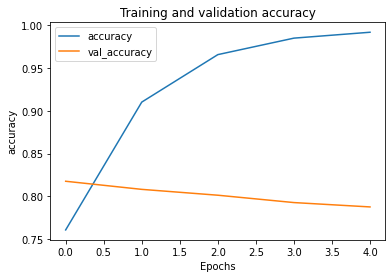

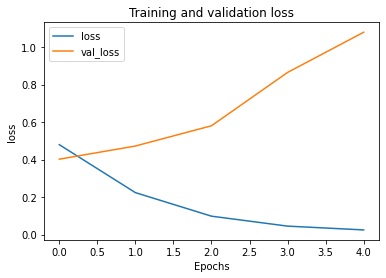

In [71]:
def plot_graphs(model, string):
  plt.plot(model.history[string])
  plt.plot(model.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plt.title('Training and validation accuracy')
plot_graphs(history, "accuracy")
plt.title('Training and validation loss')
plot_graphs(history, "loss")

In [73]:
def predict_sarcasm(s):
    x_final = pd.DataFrame({"headline":[s]})
    test_lines = denoise_text(s)
    test_sequences = Tokenizer().texts_to_sequences(x_final)
    test_review_pad = pad_sequences(test_sequences, maxlen=maxlen, padding='post')
    pred = model.predict(test_review_pad)
    pred*=100
    if pred[0][0]>=50: 
      return "It's a sarcasm!" 
    else: 
      return "It's not a sarcasm."

In [80]:
predict_sarcasm("I'm being serious")

1/1 [==============================] - 0s 32ms/step


"It's not a sarcasm."